In [ ]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# https://yq.aliyun.com/articles/174270
# Machine Learning Repository --->   https://archive.ics.uci.edu/ml/index.php
# dataset:https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data?spm=a2c4e.11153940.blogcont174270.14.3f8b65ffBqDAbF&file=Beijing+PM2.5+Data


# data description
# no, year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,lws,ls,lr
# 行号，年，月，日，时，浓度，露点温度，温度，压力，风向，风速，积雪的时间



In [2]:
from pandas import read_csv
from datetime import datetime
# data clean
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# year_month_day_hour ,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir.
dataset.drop('No', axis=1, inplace=True) # 把‘No’列删除
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


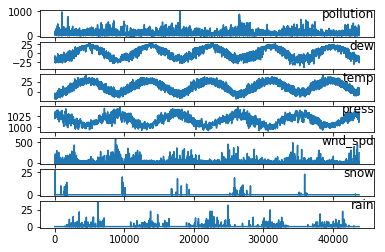

In [3]:
from pandas import read_csv
import matplotlib.pyplot as plt
%matplotlib inline
# load dataset
dataset = read_csv("pollution.csv",header = 0,index_col = 0)
values = dataset.values
# # specify columns to plot
groups = [0,1,2,3,5,6,7]  # pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
i =1 
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y =0.5,loc = 'right')
    i += 1

In [4]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline
# 多变量LSTM预测模型建立
# LSTM数据整理
# 考虑上一个时间段的污染测量和天气条件，把监督学习问题作为预测当前时刻t的污染情况。根据过去24h天气情况和污染，预测下一个小时的污染，并给出天气条件。
# convert series to supervised learning
def series_to_supervised(data,n_in = 1,n_out = 1,dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]    #type(data):pandas.core.frame.DataFrame data.shape:(43799, 16)
    df = DataFrame(data)
    cols,names = list(),list()
    # input sequence (t-n,... t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
dataset = read_csv('pollution.csv',header=0,index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,1,1)
# # drop columns not to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]],axis = 1,inplace = True)
print(reframed.head())
# 8个输入变量（输入序列）和1个输出变量（当前小时的污染水平）
# 在解决序列预测问题时，LSTM通过时间进行反向传播

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [5]:
# split into train and test dataset
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]
# split into input and outputs
train_X ,train_y = train[:,:-1],train[:,-1]
test_X,test_y = test[:,:-1],test[:,-1]
# reshape input to be [samples,timesteps,features] 对输入数据reshape
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/100
 - 2s - loss: 0.0053 - val_loss: 0.0064
Epoch 2/100
 - 1s - loss: 0.0014 - val_loss: 0.0057
Epoch 3/100
 - 1s - loss: 0.0010 - val_loss: 0.0022
Epoch 4/100
 - 1s - loss: 9.9952e-04 - val_loss: 0.0014
Epoch 5/100
 - 1s - loss: 9.9363e-04 - val_loss: 0.0011
Epoch 6/100
 - 1s - loss: 9.9004e-04 - val_loss: 9.6709e-04
Epoch 7/100
 - 1s - loss: 9.8670e-04 - val_loss: 9.2752e-04
Epoch 8/100
 - 1s - loss: 9.8432e-04 - val_loss: 9.1118e-04
Epoch 9/100
 - 1s - loss: 9.8223e-04 - val_loss: 9.0335e-04
Epoch 10/100
 - 1s - loss: 9.8047e-04 - val_loss: 8.9992e-04
Epoch 11/100
 - 1s - loss: 9.7837e-04 - val_loss: 8.9918e-04
Epoch 12/100
 - 1s - loss: 9.7623e-04 - val_loss: 9.0004e-04
Epoch 13/100
 - 1s - loss: 9.7383e-04 - val_loss: 9.0132e-04
Epoch 14/100
 - 1s - loss: 9.7148e-04 - val_loss: 9.0255e-04
Epoch 15/100
 - 1s - loss: 9.6918e-04 - val_loss: 9.0333e-04
Epoch 16/100
 - 1s - loss: 9.6709e-04 - val_loss: 9.0298e-04
Epoch 17/100
 - 

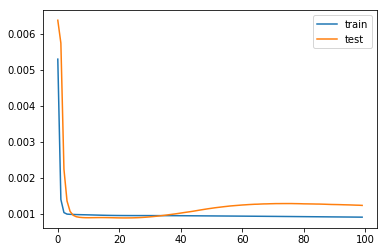

In [6]:
# define lstm model
model = Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')
# model.compile(loss = 'mae',optimizer = 'adam')
# fit the network
history = model.fit(train_X,train_y,epochs = 100,batch_size = 24,validation_data = (test_X,test_y),verbose = 2,shuffle = False)
# plot history
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'test')
plt.legend()